# Phase 2 Final Project

* Student name: Caroline Surratt
* Student pace: Self-Paced
* Scheduled project review date/time: 
* Instructor name: Morgan Jones

# Business Understanding

This analysis was conducted for a company that is interested in creating original video content. However, they lack insight as to what types of films are currently performing best at the box office. This analysis seeks to understand patterns and trends in movie performance in order to recommend what types of films the company should produce to maximize profit. 

For the purpose of this analysis, movie performance will be evaluated using: 

* total gross revenue
* percent return on investment (using gross revenue and production budget)

While other factors (consumer ratings, critic reviews, etc.) may be meaningful in the context of analyzing film as an art form, this company is not necessarily interested in producing Academy-Award-winning films. Rather, they are concerned with earning a profit and maximizing their investments in the new movie studio.

In order to better understand what types of films are performing best, I will examine the relationships between revenue and movie characteristics, including production budget, genre, and runtime. 

# Data Understanding

Two datasets were used for this analysis.

The first dataset is from The Numbers. This dataset contains information about nearly 6,000 film budgets and revenues from 1915-2020, with most entries falling between the years 2000-2012. This dataset is stored in this repository as a compressed CSV file.

The second dataset is from IMDB. This dataset is a SQLite database with information about over 146,000 movies, including information about each movie's length, when it was released, and its genre. This database also contains information about actors/actresses, directors, and writers, as well as which films they are associated with.

White there are significantly more entries in IMDB, this information will not be useful to the company without additional information about the profitability of the movie. Therefore, only entries in IMBD that have a corresponding entry in The Numbers dataset will be considered.

# Importing Data and Packages

First, I will import the libraries and packages necessary for this analysis.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

#turned off chained assignment warning, as I was receiving false positive warnings
pd.options.mode.chained_assignment = None

### The Numbers Dataset

Now, I will import the dataset from The Numbers and preview the DataFrame.

In [2]:
numbers = pd.read_csv("data/tn.movie_budgets.csv.gz")
numbers

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [3]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


This dataset contains information about the budgets and revenues of nearly 6,000 movies, with no missing entries. 

Before much of the data can be utilized, the numbers must be converted to integers instead of objects. For the columns with currency values, I will remove the $ symbol and commas in order to convert these values to a usable type.

The only necessary information from the release_date column is the year, as this is the information that is also contained in the IMDB table. Therefore, I will also adjust the release_date column to only contain the year. This way,  this column can be used to match movies to their corresponding entries across the two datasets.

In [4]:
# created a list of the columns that are referring to a currency
currency_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

# used a for loop to remove '$' and ',' symbols from the entries in these columns and convert the remaining
# characters to integers instead of strings
for column in currency_columns:
    numbers[column] = numbers[column].str.replace("$", "")
    numbers[column] = numbers[column].str.replace(",", "")
    numbers[column] = numbers[column].astype(int)

# used a labmda function to select only the year from the release_date column and dropped the column with entire date
numbers['release_year'] = numbers['release_date'].map(lambda x: int(x[-4:]))
numbers.drop('release_date', axis=1, inplace=True)

Now that the columns with numeric values are of a numeric type, we can take a look at the descriptive statistics for this dataset, beginning with the release year.

In [5]:
numbers['release_year'].describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: release_year, dtype: float64

This dataset contains entries about movies that were released as early as 1915. Because the company is interested in films that are currently doing well and film trends have changed significantly in the last century, I will limit this analysis to films that were produced in the 21st century (the year 2000 or later). This will still leave a substantial portion (over 75%) of the dataset for us to work with.

In [6]:
numbers = numbers.loc[numbers['release_year'] >= 2000]

In [7]:
numbers.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year
count,4387.000000,4.387000e+03,4.387000e+03,4.387000e+03,4387.000000
mean,50.086848,3.450823e+07,4.183110e+07,9.693220e+07,2009.314110
std,28.612598,4.550905e+07,7.126866e+07,1.862101e+08,5.275648
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,2000.000000
25%,25.000000,5.000000e+06,5.507370e+05,2.689139e+06,2005.000000
50%,50.000000,1.800000e+07,1.533129e+07,2.936714e+07,2010.000000
75%,75.000000,4.300000e+07,5.174905e+07,1.014737e+08,2014.000000
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2020.000000


These statistics show that on average, films released from 2000-2020 cost approximately \\$18,000,000  to produce, and on average, films brought in approximately \\$29,400,000 in worldwide gross revenue.

Looking at total gross revenue will give us some sense of what types of films perform best overall, but it will also be useful to consider the relationship between revenue and production budget. Therefore, I will create a new column called "%_return" that gives the gross revenue as a percentage of the production budget. The formula used can be seen in the cell below. I will also sort the dataframe by this column so that the most profitable films are easily accessible.

In [10]:
numbers['%_return'] = (numbers['worldwide_gross']-numbers['production_budget'])/numbers['production_budget']*100
numbers.sort_values(by=['%_return'], ascending=False, inplace=True)

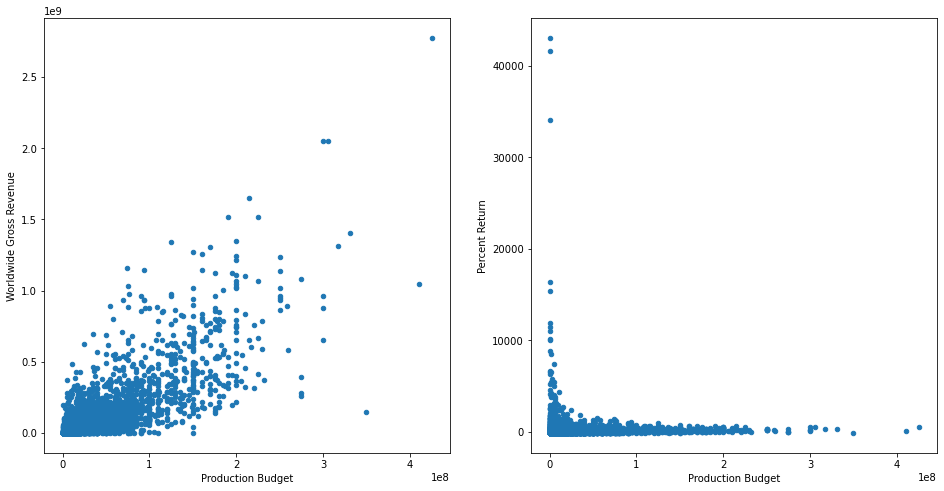

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

numbers.plot.scatter(x="production_budget", y="worldwide_gross", ax=axes[0])
axes[0].set_xlabel("Production Budget")
axes[0].set_ylabel("Worldwide Gross Revenue")

numbers.plot.scatter(x="production_budget", y="%_return", ax=axes[1])
axes[1].set_xlabel("Production Budget")
axes[1].set_ylabel("Percent Return");

The scatter plot on the left illustrates the relationship between production budget and worldwide gross revenue. Although this relationship is not linear and does not meet the criteria for performing a linear regression, there does appear to be somewhat of a weak relationship between budget and revenue: films with larger budgets tend to have larger revenues. 

The scatter plot to the right illustrates the relationship between production budget and percent return on the budget. Interestingly, the films with the highest percent returns have some of the lowest budgets. These films will be of particular interest to the company, as they demonstrate opportunities to generate impressive returns on investments.

In order to better understand the relationship between films with the highest percent return on investment, I binned the data according to this feature and examined the budget using the function below.

In [12]:
def calculate_production_budget(n):
    top_n = numbers.head(n)
    production_budget = top_n['production_budget'].mean()
    print("The production budget for the ", n, " films with the highest percent return is $", 
          round(production_budget), ".")

In [13]:
for n in 10, 25, 50, 100, 250, 500:
    calculate_production_budget(n)

The production budget for the  10  films with the highest percent return is $ 277310.0 .
The production budget for the  25  films with the highest percent return is $ 1599324.0 .
The production budget for the  50  films with the highest percent return is $ 2962062.0 .
The production budget for the  100  films with the highest percent return is $ 5161531.0 .
The production budget for the  250  films with the highest percent return is $ 13492643.0 .
The production budget for the  500  films with the highest percent return is $ 26151638.0 .


Again, there is not a linear relationship between the production budget and the percent return, but average production budgets produced above illustrate the following: The films that earn the most money per dollar (that is, the films that have the highest return on investment) have lower budgets, on average, than other films.

This led me to question: Are the budgets of these highly profitable movies different from the budgets of all other movies? In order to examine this question, I will use a t-test.

**Null hypothesis**: Highly profitable movies have the same production budgets as all other movies.

**Alternative hypothesis**: Highly profitable movies have the different production budgets than other movies.

I will consider highly profitable movies to be the 30 movies with the highest percent return on investment.

In [17]:
subset = numbers.head(30)
subset.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,%_return
count,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,30.000000
mean,50.733333,1.929437e+06,5.104841e+07,1.106746e+08,2008.733333,10535.070634
std,28.146089,2.520212e+06,5.677012e+07,1.193496e+08,4.891466,10469.339329
min,8.000000,1.100000e+03,1.543300e+04,1.810410e+05,2001.000000,3819.892912
25%,20.750000,2.125000e+05,1.134583e+07,3.551909e+07,2004.250000,4679.867755
50%,54.000000,1.000000e+06,3.164526e+07,6.407064e+07,2008.500000,6576.359233
75%,72.750000,2.750000e+06,7.326685e+07,1.664531e+08,2012.000000,10788.585900
max,99.000000,1.080000e+07,2.414382e+08,4.848730e+08,2017.000000,43051.785333


On average, these top 30 movies have a production budget of $1,929,437, which is much lower than the average budget for all movies. 

Is this difference statistially significant?

In [18]:
sample = subset['production_budget'].to_numpy()

In [20]:
mu = numbers['production_budget'].mean()

In [21]:
stats.ttest_1samp(a=sample, popmean=mu)

Ttest_1sampResult(statistic=-70.80412223288555, pvalue=4.840829029209225e-34)

Using the t-statistic and p-value calculated above, we can **reject the null hypothesis** at the standard alpha level of 0.05: it is extremely unlikely that the production budgets of highly profitable movies are a subset of the productiuon budgets of all movies. 

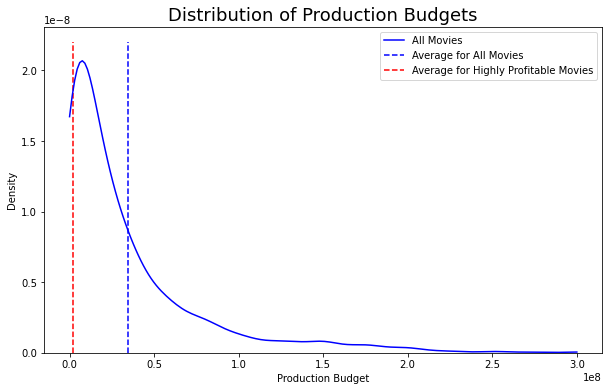

In [53]:
plt.figure(figsize=(10,6))
sns.kdeplot(numbers['production_budget'], color='blue', 
            label='All Movies', legend=True, clip=(0, 300000000))
#sns.kdeplot(subset['production_budget'], color='red', 
            #label='Highly Profitable Movies', legend=True)
plt.vlines(x=numbers['production_budget'].mean(), ymin=0, ymax=0.000000022,
          color='blue', linestyles='dashed', label='Average for All Movies')
plt.vlines(x=subset['production_budget'].mean(), ymin=0, ymax=0.000000022,
          color='red', linestyles='dashed', label='Average for Highly Profitable Movies')
plt.xlabel("Production Budget")
plt.title("Distribution of Production Budgets", fontsize=18)
plt.legend();

We cannot assume that the production budget *caused* these films to be more profitable. However, this difference in production budget is a statistically significant feature of highly profitable movies.

**Therefore, I recommend that the company mimic the production budgets of these highly profitable films and limit production budgets to $2 million.**

### IMDB

In order to better understand the features of these movies and evaluate whethere there are trends and patterns in the data, we will need to incorporate additional information from the IMDB file. In the cell below, I will connect to the IMDB file using SQLite 3. Then, I will merge the IMDB data with the data from The Numbers. Entries that have insufficient information will not be useful to this analysis: therefore, an inner merge will be used.

In [ ]:
conn = sqlite3.connect("data/im.db/im.db")

imdb = pd.read_sql("""
SELECT original_title, 
       start_year, 
       runtime_minutes,
       genres
FROM movie_basics;""", conn)

In [ ]:
conn.close()

In [ ]:
movies = numbers.merge(imdb, how='inner', left_on=['movie', 'release_year'], right_on=['original_title', 'start_year'])

In [ ]:
movies

Now, we have a set of 1,533 movies produced since 2000 for which we have information about their production budget, revenue, release year, runtime, and genre.

### Breaking Down Movies by Genre

In [ ]:
all_genres = list(movies['genres'].value_counts().index)

In [ ]:
# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists

def split_and_flatten(list):
    split_list = []
    for entry in list:
        split_list.append(entry.split(','))
    return set([item for sublist in split_list for item in sublist])

genres = split_and_flatten(all_genres)
genres

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*) 
               FROM movies 
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

In [ ]:
all_movie_genres = number_in_genre(genres)
all_movie_genres

In [ ]:
top_100_movies = movies.head(100)

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*)
               FROM top_100_movies
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

top_100_movie_genres = number_in_genre(genres)

In [ ]:
top_50_movies = movies.head(50)

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*)
               FROM top_50_movies
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

top_50_movie_genres = number_in_genre(genres)

In [ ]:
top_10_movies = movies.head(10)

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*)
               FROM top_10_movies
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

top_10_movie_genres = number_in_genre(genres)

In [ ]:
all_movies_genres_array = all_movie_genres['COUNT(*)'].to_numpy()
top_movies_genres_array = top_100_movie_genres['COUNT(*)'].to_numpy()

In [ ]:
contingency_table = np.array([all_movies_genres_array,
                             top_movies_genres_array])

In [ ]:
stats.chi2_contingency(contingency_table)

The extremely low p-value here suggests that these two groups are performing differently.

### Comparing Movies by Genre Visually

In [ ]:
for table in [all_movie_genres, top_100_movie_genres, top_50_movie_genres, top_10_movie_genres]:
    table['Percent of'] = table['COUNT(*)'].map(lambda x: x/(table['COUNT(*)'].sum()))
    table.drop('COUNT(*)', axis=1, inplace=True)

In [ ]:
all_movie_genres.rename(columns={'Percent of':'% of ALL Movies'}, inplace=True)

In [ ]:
top_100_movie_genres.rename(columns={'Percent of': '% of Top 100 Movies'}, inplace=True)

In [ ]:
top_50_movie_genres.rename(columns={'Percent of': '% of Top 50 Movies'}, inplace=True)

In [ ]:
top_10_movie_genres.rename(columns={'Percent of': '% of Top 10 Movies'}, inplace=True)

In [ ]:
genre_comparison = all_movie_genres.merge(top_100_movie_genres, on="genre")\
                                   .merge(top_50_movie_genres, on="genre")\
                                   .merge(top_10_movie_genres, on="genre")

In [ ]:
genre_comparison

In [ ]:
genre_comparison.plot(x='genre', y=['% of ALL Movies', '% of Top 100 Movies', '% of Top 50 Movies',
                                    '% of Top 10 Movies'], 
                      kind="bar", figsize=[12,9]);

In [ ]:
genre_comparison.plot(x='genre', y=['% of ALL Movies', '% of Top 50 Movies'], 
                      kind="bar", figsize=[12,9]);

In [ ]:
genre_comparison.plot(x='genre', y=['% of ALL Movies', '% of Top 10 Movies'], 
                      kind="bar", figsize=[12,9]);

In [ ]:
top_10_movies.hist('runtime_minutes', bins=20);

In [ ]:
top_100_movies.hist('runtime_minutes', bins=20);

In [ ]:
movies.hist('runtime_minutes', bins=20)

In [ ]:
top_10_movies.hist('production_budget', bins=20);

In [ ]:
top_50_movies.hist('production_budget', bins=20);

In [ ]:
movies.hist('production_budget', bins=20);